In [31]:
# import needed packages

import pandas as pd
import datarobot as dr
import math
import matplotlib.pyplot as plt

# read in master data 
NGIC = pd.read_csv("/Users/quncai.zou/Documents/NGIC/input_data_data_robot.csv", encoding = 'ISO-8859-1')
pd.options.display.max_columns = 112 # enable options to show all the columns
NGIC.head()

In [96]:
# define function NGIC_Data_subset_pd: to get the data for state/coverage (PD) segment and upload it to DR
def NGIC_Data_subset(projectname, feature_list):
    dr.Client(token='NWRjNGZhNjMzNGE5ODcwZDQzZmZiN2E0OnpyZzV5STI5VEVxeTNwbU9JV1h5eHNMQzhLWHBUbURKSFE5MWVueFNGblk9', endpoint='https://app.datarobot.com/api/v2')
    project = dr.Project.create(sourcedata, project_name=projectname)
    featurelist = project.create_featurelist('feature_base', feature_list)
#     project.start_autopilot(featurelist.id)

In [37]:
def loss_ratio_relativity(PROJECT_ID, MODEL_ID, current_pred, loss):
# get predictions for holdout set
    model = dr.Model.get(project=PROJECT_ID, model_id=MODEL_ID)
    # Calculate new training predictions on holdout partition of dataset
    training_predictions_job = model.request_training_predictions(dr.enums.DATA_SUBSET.HOLDOUT)
    training_predictions = training_predictions_job.get_result_when_complete()
    # Fetch training predictions as data frame
    preds = training_predictions.get_all_as_dataframe()
    print(preds.head())
    print("done with predictions")
# merge downloaded predictions with original data to get additional features

    prediction_actual = pd.merge(preds,sourcedata,on="row_id",how="left")
    print(prediction_actual.head())
    return prediction_actual

In [98]:
# state: NY, Coverage: pd - need to change state, coverage, and theoretical premium every time

f_filter = 'GoverningStateCode == "NY" and pdexp > 0 and pdprem_theo > 0' # pls change "NY" and pdprem_theo to corresponding state and coerage
projectname = 'NGIC_NY_PD_w_offset' # pls change project name to corresponding state/coverage
sourcedata = NGIC.query(f_filter)
sourcedata.loc[:,"offset"] = sourcedata.apply(lambda x: math.log(x.pdprem_theo), axis = 1) #pls change pdprem_theo to corresponding coverage

feature_list = ['EndorsementNum', 'VehicleNum', 'pol_year', 'term', 'tenure',
               'num_non_drv', 'num_excl_drv', 'num_oth_ins_drv','num_drv','PPAVehNum',
               'SR22','tier_rad6','BIGroup','VehAge_incept','class_ins_exp',
               'any_acc_ind_p','any_acc_ind_gt36_p','DistributionChannel','veh_hist_v2',
               'symbol8bi','symbol8cl','symbol8cp','Terr_bipd''limitbi','limitpd',
               'dedcl','dedcp','YoungDrv','OldDrv','Parent_Child','VehAge',
               'youthful_pni','youthful_on_pol','parent_child_rel_on_pol','PNIAge',
                'SpeedsCount_gt36_pol','SppCount_gt36_pol','SpdCount_gt36_pol','DwisCount_gt36_pol',
                'MinorCount_gt36_pol','MajorCount_gt36_pol','AfaCount_gt36_pol','NafaCount_gt36_pol',
                'SpeedsCount_pol','SppCount_pol','SpdCount_pol','DwisCount_pol',
                'MinorCount_pol','MajorCount_pol','AfaCount_pol','NafaCount_pol']
#call the function NGIC_Data_subset to prepare for DR project
NGIC_Data_subset(projectname, feature_list)
print("data is uploaded - go to DR and continue...")

/Users/quncai.zou/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/quncai.zou/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


TypeError: unhashable type: 'list'

(10, 3)


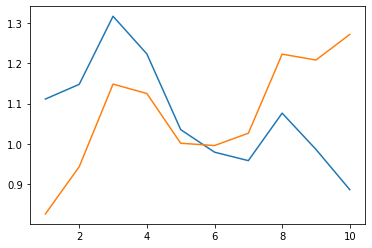

In [95]:
## get predictions for holdout dataset

PROJECT_Id = '5e46bac593165c187ab09636' #pls change to the appropriate project_id
MODEL_ID = '5e46bcb7bb76ccf3ac7ff817' #pls change to the appropriate model_id
current_pred = "pdprem_theo"          #pls change to the appropriate xxxx_theo
loss = "pdinc"                        #pls change to the appropriate project_id

sourcedata["index"] = sourcedata.index
sourcedata["row_id"] = sourcedata["index"].rank()-1
print("check 2")
output_data = loss_ratio_relativity(PROJECT_Id, MODEL_ID, current_pred, loss)
    
output_data["ratio"] = output_data["prediction"]/output_data[current_pred]
output_data['bin'] = pd.qcut(output_data['ratio'], q=10, precision=0)


LR_DR = output_data.groupby(["bin"])[loss].agg('sum')/output_data.groupby(["bin"])['prediction'].agg('sum')
LR_NGIC = output_data.groupby(["bin"])[loss].agg('sum')/output_data.groupby(["bin"])[current_pred].agg('sum')

x_bin = [1,2,3,4,5,6,7,8,9,10]
data_dict = {"bin":x_bin, "LR_DR":LR_DR, "LR_NGIC":LR_NGIC}
data_4_plot = pd.DataFrame(data_dict)

plt.plot(data_4_plot["bin"],data_4_plot["LR_DR"])
plt.plot(data_4_plot["bin"],data_4_plot["LR_NGIC"])
plt.show()